Compare this implimentation to the one from the official Tensorflow tutorial:
https://www.tensorflow.org/tutorials/generative/dcgan 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import sys
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt
import random


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML\

# watermark the notebook


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpus = tf.config.list_physical_devices('GPU')
print("GPU Resources Available:\n\t",gpus)

# getting rid of the warning messages about optimizer graph
# import logging
# logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)


# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)



EPOCHS = 500


Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.9.16 (main, Jan 11 2023, 10:02:19) 
[Clang 14.0.6 ]
GPU Resources Available:
	 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def make_grid(img_batches):
    batch = img_batches.shape[0]
    n_elem = round(np.sqrt(batch))
    i = 0
    j = 0
    size =  img_batches.shape[1]
    grid = np.zeros((n_elem*size,n_elem*size,1))
    for chan in range(batch):
        im = img_batches[chan,:,:,:]
        grid[i*size:(i+1)*size,j*size:(j+1)*size,:] = im.reshape((size,size,1))
        i += 1
        if i >= n_elem:
            i = 0
            j += 1
            if j >= n_elem:
                break # we are at the end of the grid capacity
    return grid

BATCH_SIZE = 256 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

# setup GAN dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Metal device set to: Apple M1 Max


(256, 28, 28, 1)


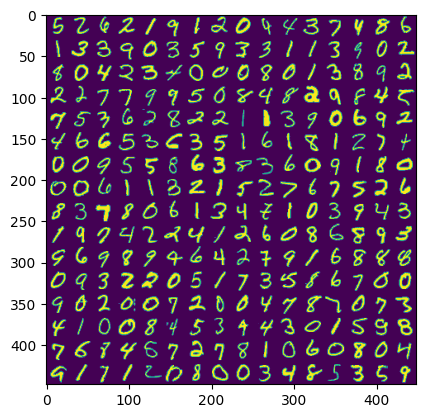

In [3]:
# get some random training images
iters = 0
for tmp in train_dataset:
    iters += 1
    
    if iters >= 1:
        break
    
tmp = tmp.numpy()
print(tmp.shape)
            
    
grid = make_grid(tmp)
plt.imshow(grid)

# Vanilla Generative Adversarial Networks
In this implementation of GANS, we will use a few of the tricks from F. Chollet and from Salimans et al. In particular, we will add some noise to the labels. The implementation is fairly similar to that from the original DC-GAN paper: https://arxiv.org/pdf/1511.06434.pdf

In [4]:
from tensorflow.keras import layers
latent_dim = 100
size = 28
channels = 1


# this model originally from https://www.tensorflow.org/tutorials/generative/dcgan 
# manipulated to have different sizing possible
def make_generator_model():
    # assume we have a 100 dimensional sampling vector
    
    # First, transform the input into a 7x7 256-channels feature map, from latent space
    # latent space starts at 100, then upsamples for convolutio
    model = tf.keras.Sequential()
    int_size_4 = int(size/4)
    model.add(layers.Dense(int_size_4*int_size_4*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # reshape to imaging for convolution
    
    model.add(layers.Reshape((int_size_4, int_size_4, 256)))
    assert model.output_shape == (None, int_size_4, int_size_4, 256)  # Note: None is the batch size

    # we will use the sequential API
    # in order to create some blocks
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, int_size_4, int_size_4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    int_size_2 = int(size/2)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, int_size_2, int_size_2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, size, size, channels)

    return model


In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[size, size, channels]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


(256, 1)


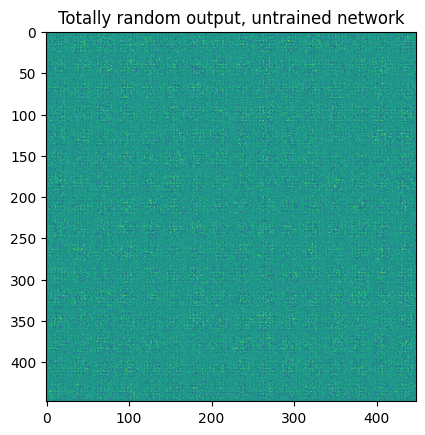

In [6]:
generator = make_generator_model()
discriminator = make_discriminator_model()

noise = tf.random.normal([BATCH_SIZE, latent_dim])
generated_image = generator(noise, training=False)

grid = make_grid(generated_image.numpy())
plt.imshow(grid)
plt.title('Totally random output, untrained network')

decision = discriminator(generated_image)
print(decision.numpy().shape) # print out 256 decisions

In [7]:
# Define the output as normal GAN
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # binary cross entropy 

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [8]:
        
# Is AdaM good here? Would that improve performance? :) 
# Decay rate adjustment? 
# set discriminator learning higher than generator?
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



In [9]:
# create Utils functions for saving and loading 
checkpoint_dir = 'models/gan_models/tf_training_checkpoints/' 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
    

In [10]:
EPOCHS = 50
num_examples_to_generate = 64 # 8x8 grid of thr outputs, for testing over time

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
test_latent_dims = tf.random.normal([num_examples_to_generate, latent_dim])

In [11]:
def checkpoint_images(model, test_input, file_prefix):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    grid = make_grid(predictions.numpy())
    
    np.save(f'models/gan_models/{file_prefix}_images.npy',grid)
    
    return grid

In [12]:
%%time

import time



# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # get some random noise for generating images
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # send through the generator
        generated_images = generator(noise, training=True)

        # save the output from discrimnator for actual batch and generated
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # get loss for generator to fool discriminator 
        gen_loss = generator_loss(fake_output)
        # get loss for generator to tell the difference
        disc_loss = discriminator_loss(real_output, fake_output)
        
    
    # now update the models with their optimizers
    # only update the correct models with the specified gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
img_list = []
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        train_step(image_batch)


    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_dir+'vanilla_tf')
        # Produce images for animation
        tmp = checkpoint_images(generator,
                                 test_latent_dims,
                                'vanilla_tf')
        img_list.append(tmp)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Time for epoch 1 is 11.979689836502075 sec
Time for epoch 2 is 10.413725852966309 sec
Time for epoch 3 is 10.376152992248535 sec
Time for epoch 4 is 10.430002927780151 sec
Time for epoch 5 is 10.556962013244629 sec
Time for epoch 6 is 10.400744915008545 sec
Time for epoch 7 is 10.398305654525757 sec
Time for epoch 8 is 10.502541065216064 sec
Time for epoch 9 is 10.383846998214722 sec
Time for epoch 10 is 10.663470029830933 sec
Time for epoch 11 is 10.462099075317383 sec
Time for epoch 12 is 10.43798279762268 sec
Time for epoch 13 is 10.461164951324463 sec
Time for epoch 14 is 10.451680898666382 sec
Time for epoch 15 is 10.586276769638062 sec
Time for epoch 16 is 10.44860315322876 sec
Time for epoch 17 is 10.561942100524902 sec
Time for epoch 18 is 10.497995138168335 sec
Time for epoch 19 is 10.44763708114624 sec
Time for epoch 20 is 10.530197143554688 sec
Time for epoch 21 is 10.425804138183594 sec
Time for epoch 22 is 10.406774997711182 sec
Time for epoch 23 is 10.416734218597412 sec


## Model Checkpointing
Let's load up a previous run and see how the images evolved over the run. The blocks below use the state_dict property to save and load data. The second block is nice for running this notebook only to show the results of a previous run. 

In [13]:
# everythign is saved in the model checkpoitn code
# load the models (nice for showing results from previous run)
print(os.listdir(checkpoint_dir))

['vanilla_tf-9.index', 'vanilla_tf-9.data-00000-of-00001', 'vanilla_tf-8.data-00000-of-00001', 'vanilla_tf-13.data-00000-of-00001', '.DS_Store', 'checkpoint', 'vanilla_tf-12.data-00000-of-00001', 'vanilla_tf-12.index', 'vanilla_tf-10.index', 'vanilla_tf-11.data-00000-of-00001', 'vanilla_tf-10.data-00000-of-00001', 'vanilla_tf-1.data-00000-of-00001', 'vanilla_tf-2.data-00000-of-00001', 'vanilla_tf-3.data-00000-of-00001', 'vanilla_tf-8.index', 'vanilla_tf-5.data-00000-of-00001', 'vanilla_tf-11.index', 'vanilla_tf-4.data-00000-of-00001', 'vanilla_tf-7.data-00000-of-00001', 'vanilla_tf-6.data-00000-of-00001', 'vanilla_tf-13.index', 'vanilla_tf-2.index', 'vanilla_tf-4.index', 'vanilla_tf-6.index', 'vanilla_tf-1.index', 'vanilla_tf-3.index', 'vanilla_tf-7.index', 'vanilla_tf-5.index']


In [14]:
# generator_loaded = make_generator_model()
# generator_loaded.load_weights(checkpoint_dir+'vanilla_tf-13.data-00000-of-00001')

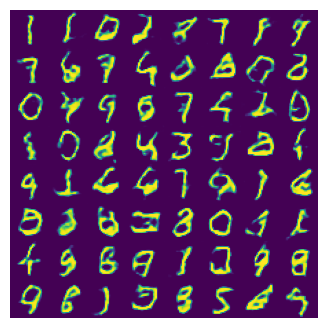

In [15]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(im, animated=True)] for im in img_list]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

We are getting something that is similar to the ground truth dataset. 

To improve this result, there are a number of things we might try such as:
- Adding more randomization to the optimizer
- Running the discriminator multiple times for each generator update
- Changing the objective function (let's try this one)

____
# Least Squares GAN
What happens if we change the objective function for training the GAN? Actually, the only thing we need to do here is replace the adversarial loss function. Note that we are NOT going to make additions to the architecture where the one hot encoding of the classes (and random classes) are used in both the generator and discriminator in the LS-GAN paper (https://arxiv.org/abs/1611.04076). This means that we might see a bit more mode collapse in our implementation. 

In [16]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the output as normal GAN
mse_loss = tf.keras.losses.MeanSquaredError()  

def discriminator_loss_mse(real_output, fake_output):
    real_loss = mse_loss(tf.ones_like(real_output), real_output)
    fake_loss = mse_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss_mse(fake_output):
    return mse_loss(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss_mse(fake_output)
        disc_loss = discriminator_loss_mse(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
%%time

# code is the exact same as above, except the prefix is different
# because we have changed the adversarial loss function
# Start training loop

img_list = []
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        train_step(image_batch)


    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_dir+'mse_tf')
        # Produce images for animation
        tmp = checkpoint_images(generator,
                                 test_latent_dims,
                                'mse_tf')
        img_list.append(tmp)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        

Time for epoch 1 is 11.72940707206726 sec
Time for epoch 2 is 10.500410795211792 sec
Time for epoch 3 is 10.505685091018677 sec
Time for epoch 4 is 10.32620906829834 sec
Time for epoch 5 is 10.46609091758728 sec
Time for epoch 6 is 10.369417905807495 sec
Time for epoch 7 is 10.33267092704773 sec
Time for epoch 8 is 10.368406057357788 sec
Time for epoch 9 is 10.330384254455566 sec
Time for epoch 10 is 10.47800612449646 sec
Time for epoch 11 is 10.35555100440979 sec
Time for epoch 12 is 10.411491870880127 sec
Time for epoch 13 is 10.565294742584229 sec
Time for epoch 14 is 10.440510988235474 sec
Time for epoch 15 is 10.535609006881714 sec
Time for epoch 16 is 10.391196727752686 sec
Time for epoch 17 is 10.351218938827515 sec
Time for epoch 18 is 10.475823879241943 sec
Time for epoch 19 is 10.520672082901001 sec
Time for epoch 20 is 10.613070249557495 sec
Time for epoch 21 is 10.406102657318115 sec
Time for epoch 22 is 10.37225604057312 sec
Time for epoch 23 is 10.61331582069397 sec
Time 

In [19]:
# Load up a run, if you want 


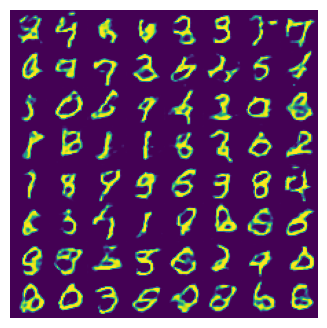

In [20]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(im, animated=True)] for im in img_list]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Well, these results are not exactly a great improvement. Mode collapse is more apparent here as well, but the fine structure of the numbers is also not quite the improvement that we wanted. Looking back through the iterations, there was some indication of more successful generations.  We could run this code for many more iterations, and that might work in terms of getting the optimizers to create better distributions. But it is not guaranteed. 

Instead, now let's try using a Wasserstein GAN, where we use the gradient penalty as a method of making the discrminator 1-lipschitz (and therefore a valid critic to approximate the earth mover distance). 

___
# Wasserstein GAN with Gradient Penalty
For this implementation, we need to add functionality to the gradient of the Discriminator to make it a critic. For the most part, we need to add the gradient loss function calculations to match the WGAN-GP.

This compute_gradient_penalty function for WGAN-GP comes from https://keras.io/examples/generative/wgan_gp/

In [12]:
# Initialize generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

#---------------------------
# params from WGAN-GP paper
#---------------------------
# number of training steps for discriminator per iter for WGANGP
n_critic = 3
# Loss weight for gradient penalty
lambda_gp = 10

generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)



In [13]:
# create Utils functions for saving and loading 
checkpoint_dir = 'models/gan_models/tf_training_checkpoints/' 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
# code from https://keras.io/examples/generative/wgan_gp/
# def gradient_penalty(real_images, fake_images):
#     """Calculates the gradient penalty.

#     This loss is calculated on an interpolated image
#     and added to the discriminator loss.
#     """
#     # Get the interpolated images
#     curr_batch_size = tf.shape(real_images)[0]
#     alpha = tf.random.normal([curr_batch_size, 1, 1, 1], 0.0, 1.0)
#     diff = fake_images - real_images
#     interpolated = real_images + alpha * diff

#     with tf.GradientTape() as gp_tape:
#         gp_tape.watch(interpolated)
#         # 1. Get the discriminator output for this interpolated image.
#         pred = discriminator(interpolated, training=True)

#     # 2. Calculate the gradients w.r.t to this interpolated image.
#     grads = gp_tape.gradient(pred, [interpolated])[0]
    
#     # 3. Calculate the norm of the gradients.
#     norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
#     gp = tf.reduce_mean((norm - 1.0) ** 2) # is norm close to 1?
#     return gp

In [15]:

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss # minimize (slides have max in them)


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img) # minimize (slides have max in them)


# mostly, code from https://keras.io/examples/generative/wgan_gp/
@tf.function # commenting this as there is some problem with non-eager...
def train_step(images):


    # Train the discriminator first. The original paper recommends training
    # the discriminator for `x` more steps (typically 5) as compared to
    # one step of the generator. Here we will train it for 3 extra steps
    # as compared to 5 to reduce the training time.
    batch_size = tf.shape(images)[0]

    for i in range(3):

        # Get the latent vector
        noise = tf.random.normal([batch_size, latent_dim])

        with tf.GradientTape() as disc_tape:

            # Generate fake images from the latent vector
            generated_images = generator(noise, training=True)

            # also get interpolations for the gradient penalty
            alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
            diff = generated_images - images
            interpolated = images + alpha * diff

            # Get the logits for the fake images
            fake_output = discriminator(generated_images, training=True)

            # Get the logits for the real images
            real_output = discriminator(images, training=True)

            # Calculate the discriminator loss using the fake and real image logits
            disc_loss = discriminator_loss(real_output,fake_output)

            # code from https://keras.io/examples/generative/wgan_gp/
            # Calculate the gradient penalty
            with tf.GradientTape(watch_accessed_variables=False) as gp_tape:
                gp_tape.watch(interpolated) # manually define what to watch
                # 1. Get the discriminator output for this interpolated image.
                pred = discriminator(interpolated, training=True)

            # Calculate the gradients w.r.t to this interpolated image.
            grads = gp_tape.gradient(pred, [interpolated])[0]

            # Calculate the norm of the gradients.
            norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
            gp = tf.reduce_mean((norm - 1.0) ** 2) # is norm close to 1?

            # Add the gradient penalty to the original discriminator loss
            d_loss = disc_loss + gp * lambda_gp

        # Get the gradients w.r.t the discriminator loss
        gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

        # Update the weights of the discriminator using the discriminator optimizer
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



    # Train the generator
    # Get the latent vector
    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as gen_tape:
        # Generate fake images using the generator
        generated_images = generator(noise, training=True)
        # Get the discriminator logits for fake images
        fake_output = discriminator(generated_images, training=True)

        # Calculate the generator loss
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    

In [ ]:
#%%time

import time
# code is the exact same as above, except the prefix is different
# because we have changed the loss calculation to be a wasserstein critic
# Start training loop

EPOCHS = 20 # changed this to be lesser 

img_list = []
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        train_step(image_batch)


    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
        # checkpoint.save(file_prefix = checkpoint_dir+'wgan_tf')
        # Produce images for animation
        tmp = checkpoint_images(generator,test_latent_dims,'wgan_tf')
        img_list.append(tmp)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
# EAGER execution: 61s /epoch
# COMPILED (comp graph): 37s/epoch
# TODO: beyond 20 EPOCHS, had this program hang. Cannot seem to debug why...
#.   Is this an M1 error? 

Time for epoch 1 is 37.82436394691467 sec


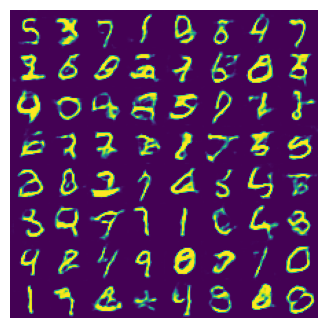

In [17]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(im, animated=True)] for im in img_list]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

The WGAN-GP seem to be a bit better (on some runs) for finding more divers backgrounds. You can also notice that one of the runs seems to start finding legs, which is something the other methods struggled with. 